# Bot de inversion para cripto

In [50]:
#!pip install yfinance
#!pip install mpl_finance
#!pip install python-binance

## import dependencies

In [56]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import datetime
from binance import Client
from config import API_Key,Secret_Key


## Gathering data with binance api

In [63]:
client = Client(API_Key, Secret_Key)

In [89]:
# get historical kline data from any date range
#BTCOIN USDOLAR PRICE
#first currency and crypto,then time interval, 
# and time to go back

#def get_crypto_data(crypto, interval, lookback):
pd.DataFrame(client.get_historical_klines('ETHUSDT','1m','1 day ago UTC')).head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,1637025720000,4379.99000000,4389.04000000,4379.02000000,4389.04000000,597.12690000,1637025779999,2617022.21775600,1963,310.13860000,1359144.04738700,0
1,1637025780000,4389.03000000,4396.64000000,4383.15000000,4391.61000000,1487.80140000,1637025839999,6534560.03257500,2422,857.50690000,3766404.52934900,0
2,1637025840000,4391.60000000,4393.46000000,4380.48000000,4381.20000000,536.25610000,1637025899999,2353367.10287700,1618,265.57770000,1165513.43317400,0
3,1637025900000,4380.97000000,4384.05000000,4373.31000000,4376.30000000,888.21280000,1637025959999,3888072.17790900,1708,364.07860000,1593572.18791500,0
4,1637025960000,4376.29000000,4379.52000000,4367.07000000,4370.02000000,901.18470000,1637026019999,3942075.85858700,1654,338.00530000,1478503.84170500,0


## Read File

In [3]:
file_to_open = os.path.join('Resources/BTCUSDT=BNNC.csv')
BTC_data_complete_df = pd.read_csv(file_to_open)
BTC_data_complete_df.shape

(17439, 11)

In [4]:
# 10 sample rows
BTC_data_complete_df.sample(10)

,Date (GMT),Open,High,Low,Last,Volume,MACD,MACD Signal Line,BBandUp,BBandMid,BBandLow
17168,10/25/2021 6:00,62087.25,62124.99,61764.45,61836.78,648.3858,363.152213,325.642969,62520.64397,61520.40157,60520.15917
10375,6/5/2021 10:30,36337.35,36697.53,36022.69,36629.61,3274.8745,-37.498935,91.441923,38148.71421,37357.67724,36566.64028
7690,4/9/2021 13:30,58502.37,58626.72,58430.00,58597.15,880.5441,196.409725,156.385352,58898.47737,58250.82326,57603.16916
4391,1/30/2021 15:30,34234.73,34299.00,34057.22,34218.74,1199.6375,-38.475665,-112.370291,34617.21889,34046.45738,33475.69588
4270,1/28/2021 3:00,30932.88,31188.76,30900.00,30981.42,1190.2333,-24.773789,-84.776157,31590.29063,30724.99869,29859.70674
2795,12/28/2020 9:30,26940.79,27000.00,26750.66,26997.97,1428.1374,21.300798,21.423361,27364.09204,26968.94023,26573.78843
8352,4/23/2021 10:30,48233.70,49541.43,48130.03,49269.82,3089.9758,-964.592404,-1050.844314,51536.77445,49538.84593,47540.91741
11031,6/19/2021 2:30,36110.43,36226.21,35880.12,35940.67,974.5942,-244.667651,-365.264049,36797.92726,35988.63996,35179.35267
364,11/7/2020 13:00,15533.38,15541.39,15496.59,15506.58,894.1208,-5.601610,-7.567755,15584.46237,15517.08005,15449.69773
6854,3/23/2021 3:30,54557.41,54707.14,54379.96,54615.72,1034.3168,-549.602134,-614.373380,56895.54550,55144.71084,53393.87619


In [5]:
# from the complete data, set index to date
BTC_data_complete_dateindex_df = BTC_data_complete_df.\
set_index(pd.DatetimeIndex(BTC_data_complete_df['Date (GMT)'].values))
BTC_data_complete_dateindex_df.tail()

,Date (GMT),Open,High,Low,Last,Volume,MACD,MACD Signal Line,BBandUp,BBandMid,BBandLow
2021-10-30 21:00:00,10/30/2021 21:00,61943.97,61960.00,61545.05,61642.12,506.7605,14.115220,-46.717215,61983.11353,61541.88077,61100.64801
2021-10-30 21:30:00,10/30/2021 21:30,61642.12,61699.80,61474.34,61525.43,528.9094,10.023288,-35.369115,61974.93411,61540.31403,61105.69396
2021-10-30 22:00:00,10/30/2021 22:00,61525.44,61644.60,61426.04,61440.00,383.5285,-0.111796,-28.317651,61961.09053,61530.76032,61100.43010
2021-10-30 22:30:00,10/30/2021 22:30,61440.00,61574.52,61343.85,61386.59,702.3474,-12.311742,-25.116469,61944.18840,61517.02981,61089.87122
2021-10-30 23:00:00,10/30/2021 23:00,61386.59,61593.26,61175.01,61584.51,1012.9571,-6.969571,-21.487090,61957.88168,61526.42221,61094.96274


## code machine larning: Linear regresion

In [6]:
# showing only BTC price
BTC_data_price_df = BTC_data_complete_df[['Last']]
BTC_data_price_df.head(14)

#consider changing last to price, i,e, last=price

,Last
0,13553.09
1,13615.57
2,13560.10
3,13557.98
4,13615.06
5,13591.36
6,13636.14
7,13687.31
8,13611.71
9,13481.87


In [7]:
BTC_data_price_df.tail(14)

,Last
17425,61277.78
17426,61256.42
17427,61359.91
17428,61410.63
17429,61454.42
17430,61560.92
17431,61499.99
17432,61725.56
17433,61943.96
17434,61642.12


In [8]:
#  variable for predicting x number of days into the future
predict_days = 14 #numer of days, then change this info to function

# create another column shifted n units up
BTC_data_price_df['Prediction'] = BTC_data_price_df[['Last']].shift(-predict_days)

<ipython-input-8-38f198fed041>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BTC_data_price_df['Prediction'] = BTC_data_price_df[['Last']].shift(-predict_days)


In [9]:
# show df with new column
BTC_data_price_df.head(14)

,Last,Prediction
0,13553.09,13473.27
1,13615.57,13528.49
2,13560.10,13612.04
3,13557.98,13562.91
4,13615.06,13576.14
5,13591.36,13818.01
6,13636.14,13739.95
7,13687.31,13740.65
8,13611.71,13893.22
9,13481.87,13754.99


In [10]:
# show last 5 rows of new dataset
BTC_data_price_df.tail(15)

,Last,Prediction
17424,61384.08,61584.51
17425,61277.78,NaN
17426,61256.42,NaN
17427,61359.91,NaN
17428,61410.63,NaN
17429,61454.42,NaN
17430,61560.92,NaN
17431,61499.99,NaN
17432,61725.56,NaN
17433,61943.96,NaN


In [11]:
# create independent dataset, convert the dataframe to a np array and drop prediction column
a=np.array(BTC_data_price_df[['Last']])
#remove the last n rows where n is the prediction days
a=a[:-predict_days]
print(a)

[[13553.09]
 [13615.57]
 [13560.1 ]
 ...
 [61180.87]
 [61302.12]
 [61384.08]]


In [12]:
# CREATE THE DEPENDENT DATA SET
#CONVERT THE DF TO A NP ARRAY
b = BTC_data_price_df['Prediction'].values

#get all values except las n rows
b = b[:-predict_days]
print(b)

[13473.27 13528.49 13612.04 ... 61440.   61386.59 61584.51]


In [13]:
# split the data into 85% traning and 15% testing
a_train, a_test, b_train, b_test = train_test_split(a,b, test_size = 0.15, shuffle = False)

In [14]:
# create and train the model
Lreg = LinearRegression()
# train
Lreg.fit(a_train,b_train)


LinearRegression()

In [15]:
# test shows R^2 
Lreg_similarity = Lreg.score(a_test,b_test)
print('LIN REG SIMILARITY:', Lreg_similarity)

LIN REG SIMILARITY: 0.9833544615908769


In [16]:
# create variable a_projection and set equal to last 14 rows of original dataset
a_projection = np.array(BTC_data_price_df[['Last']])[-predict_days:]
print(a_projection)

[[61277.78]
 [61256.42]
 [61359.91]
 [61410.63]
 [61454.42]
 [61560.92]
 [61499.99]
 [61725.56]
 [61943.96]
 [61642.12]
 [61525.43]
 [61440.  ]
 [61386.59]
 [61584.51]]


In [17]:
# print lreg models predictions for next 14 days
Lreg_predict = Lreg.predict(a_projection)
print(Lreg_predict)

[61224.03491417 61202.76232161 61305.82882928 61356.34127753
 61399.95208409 61506.01627452 61445.3356067  61669.98254975
 61887.48883322 61586.8839953  61470.67150346 61385.5910923
 61332.39965182 61529.50974168]


In [18]:
results_compare=zip(a_projection,Lreg_predict)
results_df= pd.DataFrame(results_compare, columns = ['actual price', 'predicted price'])
results_df

,actual price,predicted price
0,[61277.78],61224.034914
1,[61256.42],61202.762322
2,[61359.91],61305.828829
3,[61410.63],61356.341278
4,[61454.42],61399.952084
5,[61560.92],61506.016275
6,[61499.99],61445.335607
7,[61725.56],61669.982550
8,[61943.96],61887.488833
9,[61642.12],61586.883995


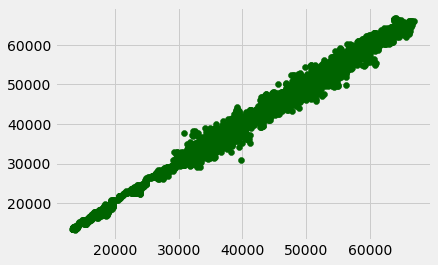

In [19]:
plt.scatter(a, b, color="DarkGreen" )

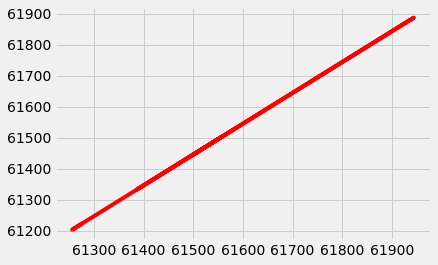

In [20]:
plt.plot(a_projection,Lreg_predict, color='r')

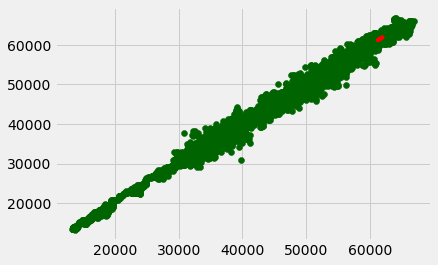

In [21]:
plt.scatter(a, b, color="DarkGreen" )
plt.plot(a_projection,Lreg_predict, color='r')
plt.show()

## MACD

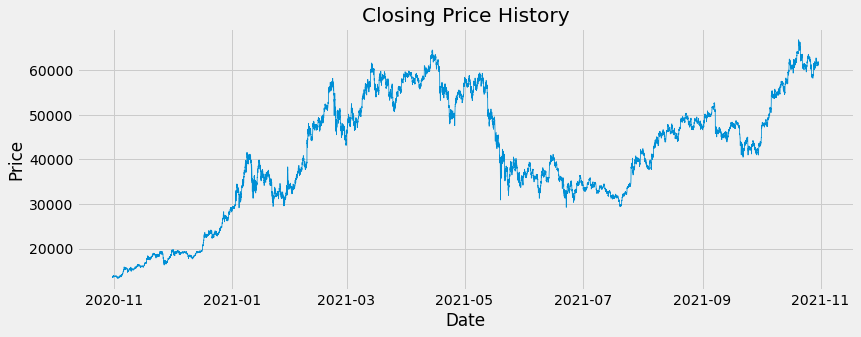

In [22]:
# plot prices
plt.figure(figsize=(12.4, 4.5))
plt.plot(BTC_data_complete_dateindex_df['Last' ], label='Closing Price',linewidth=0.8)
plt.title('Closing Price History')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [23]:
#Create DF for MACD
BTC_data_MACD_complete_df=BTC_data_complete_dateindex_df.loc[:,:'Volume']
BTC_data_MACD_complete_df.head()

,Date (GMT),Open,High,Low,Last,Volume
2020-10-30 23:00:00,10/30/2020 23:00,13597.00,13600.00,13544.86,13553.09,480.6531
2020-10-30 23:30:00,10/30/2020 23:30,13553.09,13622.52,13553.09,13615.57,655.3268
2020-10-31 00:00:00,10/31/2020 0:00,13615.56,13637.00,13535.05,13560.10,778.9061
2020-10-31 00:30:00,10/31/2020 0:30,13560.10,13577.15,13511.45,13557.98,645.0756
2020-10-31 01:00:00,10/31/2020 1:00,13557.99,13648.00,13546.53,13615.06,1148.3320


In [24]:
#Calculate MACD and signal line 
# short term EMA ewm=exponential weighted functions
BTC_data_MACD_complete_df['S_EMA']=BTC_data_MACD_complete_df.Last.ewm(span=12, adjust=False).mean()
#Long term EMA ewm=exponential weighted functions
BTC_data_MACD_complete_df['L_EMA']=BTC_data_MACD_complete_df.Last.ewm(span=26, adjust=False).mean()

#Calculate MACD line
BTC_data_MACD_complete_df['MACD_line']=\
                          BTC_data_MACD_complete_df.S_EMA-BTC_data_MACD_complete_df.L_EMA

#calculate Signal Line
BTC_data_MACD_complete_df['Sig_line']=\
                          BTC_data_MACD_complete_df.MACD_line.ewm(span=9, adjust=False).mean()
BTC_data_MACD_complete_df.head()

,Date (GMT),Open,High,Low,Last,Volume,S_EMA,L_EMA,MACD_line,Sig_line
2020-10-30 23:00:00,10/30/2020 23:00,13597.00,13600.00,13544.86,13553.09,480.6531,13553.090000,13553.090000,0.000000,0.000000
2020-10-30 23:30:00,10/30/2020 23:30,13553.09,13622.52,13553.09,13615.57,655.3268,13562.702308,13557.718148,4.984160,0.996832
2020-10-31 00:00:00,10/31/2020 0:00,13615.56,13637.00,13535.05,13560.10,778.9061,13562.301953,13557.894582,4.407371,1.678940
2020-10-31 00:30:00,10/31/2020 0:30,13560.10,13577.15,13511.45,13557.98,645.0756,13561.637037,13557.900909,3.736128,2.090377
2020-10-31 01:00:00,10/31/2020 1:00,13557.99,13648.00,13546.53,13615.06,1148.3320,13569.855954,13562.134916,7.721039,3.216510


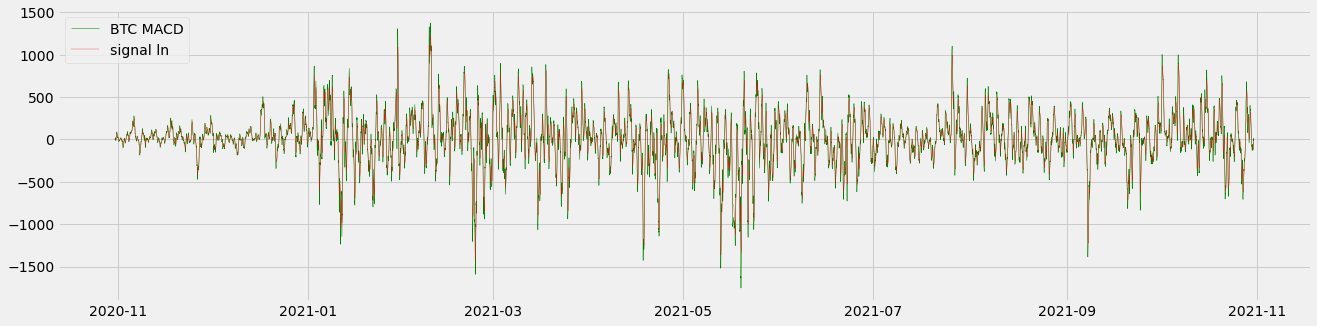

In [25]:
plt.figure(figsize=(20, 5))
plt.plot(BTC_data_MACD_complete_df.MACD_line, label='BTC MACD', color='g',linewidth=0.5)
plt.plot(BTC_data_MACD_complete_df.Sig_line, label='signal ln', color='r', linewidth=0.3)
plt.legend(loc='upper left')

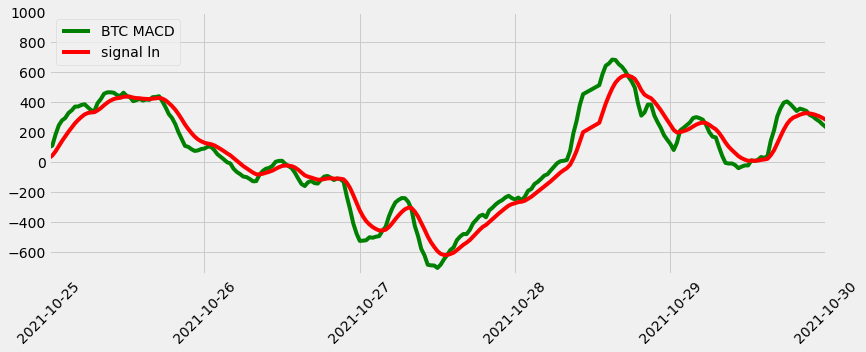

In [84]:
# plt chart
initial_date = datetime(2021,10,25)
final_date = datetime(2021,10,30)

plt.figure(figsize=(12.4, 4.5))
plt.plot(BTC_data_MACD_complete_df.MACD_line, label='BTC MACD', color='g')
plt.plot(BTC_data_MACD_complete_df.Sig_line, label='signal ln', color='r')
plt.legend(loc='upper left')
plt.xlim([initial_date,final_date])
plt.ylim([-750,1000])
plt.xticks(rotation=45)
plt.show()

In [93]:
#buy sell signal
def alert_MACD(signal):
    buy = []
    sell = []
    flag = -1
    for i in range(0,len(signal)):
        if signal['MACD_line'][i] > signal['Sig_line'][i]:
            sell.append(np.nan)
            if flag != 1:
                buy.append('1')
                flag = 1
            else:
                buy.append(np.nan)
        elif signal['MACD_line'][i] < signal['Sig_line'][i]:
            buy.append(np.nan)
            if flag != 0:
                sell.append('1')
                flag = 0
            else:
                sell.append(np.nan)
        else:
            buy.append(np.nan)
            sell.append(np.nan)
    return(buy,sell)
            

In [99]:
#create buy and sell columns in df
x=alert_MACD(BTC_data_MACD_complete_df)
BTC_data_MACD_complete_df['Buy Notification'] = x[0]
BTC_data_MACD_complete_df['Sell Notification'] = x[1]

# show df
BTC_data_MACD_complete_df.head(10)
# create df with buy and sell info
BTC_MACD_BuySell_Sig_df = BTC_data_MACD_complete_df[['Date (GMT)',
                                                    'Buy Notification', 'Sell Notification']]
BTC_MACD_BuySell_Sig_df.fillna(0).tail(50)

,Date (GMT),Buy Notification,Sell Notification
2021-10-29 22:30:00,10/29/2021 22:30,0,0
2021-10-29 23:00:00,10/29/2021 23:00,0,0
2021-10-29 23:30:00,10/29/2021 23:30,0,0
2021-10-30 00:00:00,10/30/2021 0:00,0,0
2021-10-30 00:30:00,10/30/2021 0:30,0,0
2021-10-30 01:00:00,10/30/2021 1:00,0,0
2021-10-30 01:30:00,10/30/2021 1:30,0,0
2021-10-30 02:00:00,10/30/2021 2:00,0,0
2021-10-30 02:30:00,10/30/2021 2:30,0,0
2021-10-30 03:00:00,10/30/2021 3:00,0,0


## BOLLINGER BANDS

In [40]:
#creating bollinger band dataframe
BTC_BB_df1= BTC_data_complete_dateindex_df.loc[:,:'Volume']
BTC_BB_df1.head()

,Date (GMT),Open,High,Low,Last,Volume
2020-10-30 23:00:00,10/30/2020 23:00,13597.00,13600.00,13544.86,13553.09,480.6531
2020-10-30 23:30:00,10/30/2020 23:30,13553.09,13622.52,13553.09,13615.57,655.3268
2020-10-31 00:00:00,10/31/2020 0:00,13615.56,13637.00,13535.05,13560.10,778.9061
2020-10-31 00:30:00,10/31/2020 0:30,13560.10,13577.15,13511.45,13557.98,645.0756
2020-10-31 01:00:00,10/31/2020 1:00,13557.99,13648.00,13546.53,13615.06,1148.3320


In [41]:
# calculate SMA, SD, UPPER BAN, LOWER BAND
#GET TIME PERIOD
period = 20

# calculate SMA
BTC_BB_df1['SMA']=BTC_BB_df1['Last'].rolling(window = period).mean()
#calculate std
BTC_BB_df1['STD']=BTC_BB_df1['Last'].rolling(window = period).std()
#calculate BB UP
BTC_BB_df1['BBand Upper']=BTC_BB_df1['SMA']+(BTC_BB_df1['STD']*2)
#calculate BB LOW
BTC_BB_df1['BBand Lower']=BTC_BB_df1['SMA']-(BTC_BB_df1['STD']*2)

BTC_BB_df1.head()

,Date (GMT),Open,High,Low,Last,Volume,SMA,STD,BBand Upper,BBand Lower
2020-10-30 23:00:00,10/30/2020 23:00,13597.00,13600.00,13544.86,13553.09,480.6531,NaN,NaN,NaN,NaN
2020-10-30 23:30:00,10/30/2020 23:30,13553.09,13622.52,13553.09,13615.57,655.3268,NaN,NaN,NaN,NaN
2020-10-31 00:00:00,10/31/2020 0:00,13615.56,13637.00,13535.05,13560.10,778.9061,NaN,NaN,NaN,NaN
2020-10-31 00:30:00,10/31/2020 0:30,13560.10,13577.15,13511.45,13557.98,645.0756,NaN,NaN,NaN,NaN
2020-10-31 01:00:00,10/31/2020 1:00,13557.99,13648.00,13546.53,13615.06,1148.3320,NaN,NaN,NaN,NaN


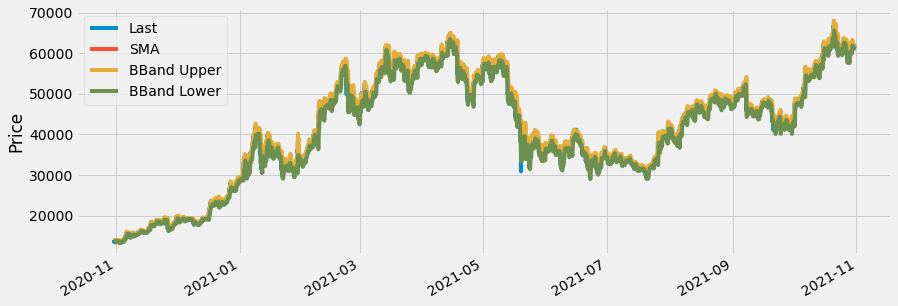

In [42]:
#list of colmns to keep
column_ls = ['Last','SMA', 'BBand Upper','BBand Lower']
#plot data
BTC_BB_df1[column_ls].plot(figsize=(13,5))

plt.ylabel('Price')
plt.show()

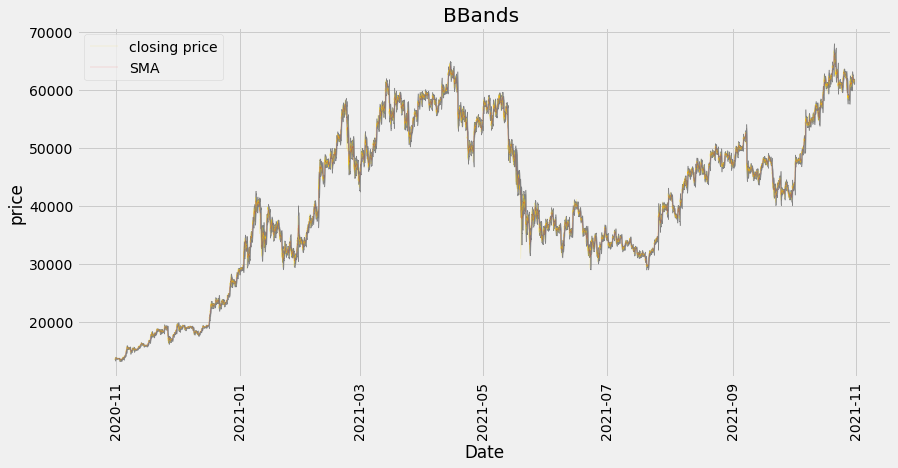

In [43]:
#list of colmns to keep
column_ls = ['Last','SMA', 'BBand Upper','BBand Lower']
#plot data
fig = plt.figure(figsize = (13,6))
ax=fig.add_subplot(1,1,1)
x_axis=BTC_BB_df1.index
ax.fill_between(x_axis,BTC_BB_df1['BBand Upper'], BTC_BB_df1['BBand Lower'], color='grey')
ax.plot(x_axis,BTC_BB_df1['Last'], color = 'gold', label='closing price', linewidth=0.1)
ax.plot(x_axis,BTC_BB_df1['SMA'], color = 'red', label='SMA', linewidth=0.1)
ax.set_title('BBands ')
ax.set_xlabel('Date')
ax.set_ylabel('price')
plt.xticks(rotation = 90)
ax.legend()
plt.show()


In [44]:
#FILTER BY DATE
date = datetime(2021,10,30)
BTC_BB_ZOOM_df = BTC_BB_df1[BTC_BB_df1.index > date]
BTC_BB_ZOOM_df.head(10)

,Date (GMT),Open,High,Low,Last,Volume,SMA,STD,BBand Upper,BBand Lower
2021-10-30 00:30:00,10/30/2021 0:30,62253.70,62359.25,61962.02,62070.87,618.9523,62279.6665,312.540176,62904.746852,61654.586148
2021-10-30 01:00:00,10/30/2021 1:00,62070.86,62235.26,61719.78,61915.37,898.4836,62313.6050,214.921485,62743.447970,61883.762030
2021-10-30 01:30:00,10/30/2021 1:30,61915.37,62063.40,61851.87,61851.90,499.8968,62285.7885,236.907278,62759.603057,61811.973943
2021-10-30 02:00:00,10/30/2021 2:00,61851.90,62139.11,61812.14,62010.05,535.6614,62271.8515,244.789278,62761.430056,61782.272944
2021-10-30 02:30:00,10/30/2021 2:30,62007.80,62045.95,61841.48,62020.01,542.9368,62232.6460,216.173296,62664.992592,61800.299408
2021-10-30 03:00:00,10/30/2021 3:00,62020.00,62031.68,61772.87,61877.63,498.1568,62195.9390,210.668143,62617.275285,61774.602715
2021-10-30 03:30:00,10/30/2021 3:30,61877.63,61950.58,61635.99,61656.86,617.8343,62148.5385,220.249346,62589.037193,61708.039807
2021-10-30 04:00:00,10/30/2021 4:00,61656.87,61798.72,61604.98,61669.43,652.2822,62112.0105,236.344632,62584.699765,61639.321235
2021-10-30 04:30:00,10/30/2021 4:30,61669.43,61914.14,61635.27,61752.01,349.4618,62091.7635,249.283067,62590.329634,61593.197366
2021-10-30 05:00:00,10/30/2021 5:00,61752.00,61768.58,61447.70,61482.01,459.8156,62061.0975,284.112417,62629.322333,61492.872667


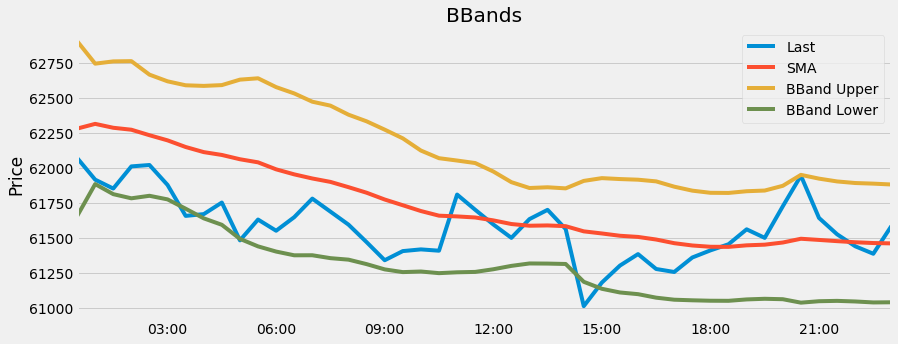

In [45]:
#list of colmns to keep
column_ls = ['Last','SMA', 'BBand Upper','BBand Lower']
#plot data
BTC_BB_ZOOM_df[column_ls].plot(figsize=(13,5))
plt.title('BBands')
plt.ylabel('Price')             
plt.show()

In [46]:
#create a new data frame7
new_df = BTC_BB_df1[:-1]
# from the complete data, set index to date
# new_df = new_df.\
# set_index(pd.DatetimeIndex(new_df['Date (GMT)'].values))
new_df.head(34)

,Date (GMT),Open,High,Low,Last,Volume,SMA,STD,BBand Upper,BBand Lower
2020-10-30 23:00:00,10/30/2020 23:00,13597.00,13600.00,13544.86,13553.09,480.6531,NaN,NaN,NaN,NaN
2020-10-30 23:30:00,10/30/2020 23:30,13553.09,13622.52,13553.09,13615.57,655.3268,NaN,NaN,NaN,NaN
2020-10-31 00:00:00,10/31/2020 0:00,13615.56,13637.00,13535.05,13560.10,778.9061,NaN,NaN,NaN,NaN
2020-10-31 00:30:00,10/31/2020 0:30,13560.10,13577.15,13511.45,13557.98,645.0756,NaN,NaN,NaN,NaN
2020-10-31 01:00:00,10/31/2020 1:00,13557.99,13648.00,13546.53,13615.06,1148.3320,NaN,NaN,NaN,NaN
2020-10-31 01:30:00,10/31/2020 1:30,13615.05,13657.16,13588.78,13591.36,861.6386,NaN,NaN,NaN,NaN
2020-10-31 02:00:00,10/31/2020 2:00,13591.35,13643.62,13571.30,13636.14,568.5373,NaN,NaN,NaN,NaN
2020-10-31 02:30:00,10/31/2020 2:30,13636.15,13740.00,13635.27,13687.31,1791.1294,NaN,NaN,NaN,NaN
2020-10-31 03:00:00,10/31/2020 3:00,13685.78,13717.05,13559.74,13611.71,1222.3967,NaN,NaN,NaN,NaN
2020-10-31 03:30:00,10/31/2020 3:30,13611.72,13621.95,13411.50,13481.87,2179.7335,NaN,NaN,NaN,NaN


In [ ]:
#buy sell signal
def alert_BBands(signal):
    buy = []
    sell = []
    flag = -1
    for i in range(0,len(signal)):
        if signal['BB'][i] > signal['Sig_line'][i]:
            sell.append(np.nan)
            if flag != 1:
                buy.append(signal['Last'][i])
                flag = 1
            else:
                buy.append(np.nan)
        elif signal['MACD_line'][i] < signal['Sig_line'][i]:
            buy.append(np.nan)
            if flag != 0:
                sell.append(signal['Last'][i])
                flag = 0
            else:
                sell.append(np.nan)
        else:
            buy.append(np.nan)
            sell.append(np.nan)
    return(buy,sell)
            

In [ ]:
#create buy and sell columns in df
x=alert_BBands(BTC_data_MACD_complete_df)
BTC_data_MACD_complete_df['Buy Notification'] = x[0]
BTC_data_MACD_complete_df['Sell Notification'] = x[1]

# show df
BTC_data_MACD_complete_df.head(10)
# create df with buy and sell info
BTC_MACD_BuySell_Sig_df = BTC_data_MACD_complete_df[['Date (GMT)',
                                                    'Buy Notification', 'Sell Notification']]
BTC_MACD_BuySell_Sig_df[:-1].head(10)

In [47]:
BTC_BB_df1['Last'].describe()

count    17439.000000
mean     41237.363590
std      13428.255433
min      13297.010000
25%      33077.190000
50%      42049.290000
75%      51841.930000
max      66875.870000
Name: Last, dtype: float64

## Machine learning svr

In [ ]:
resultsdf= pd.DataFrame(results) 

In [ ]:
mylist = [ [1,2,3], [4,5], 6 ]

list_df = pd.DataFrame([ pd.Series(value) for value in mylist ])

list_df

In [ ]:
mydict = {'one': [1,2,3], 2: [4,5,6,7], 3: 8}

dict_df = pd.DataFrame({ key:pd.Series(value) for key, value in mydict.items() })

dict_df


In [ ]:
data['Date (GMT)']